<a href="https://colab.research.google.com/github/JSchoonmaker/Research/blob/main/Twitter_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.2'
# spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
# !wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"


# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

In [ ]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataFrameBasics").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install spark-nlp==2.4.2

     |████████████████████████████████| 112kB 6.7MB/s 


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import sparknlp
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[4]")\
    .config("spark.driver.memory","4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum
from pyspark.sql.window import Window

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read in data from School shooting csv
from pyspark import SparkFiles
url = "/content/gdrive/MyDrive/schoolshootingHashtag.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("schoolshootingHashtag.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+-------------------+-------------------+--------------------+----------+--------+--------+-------------------+------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+-----+--------------------+----+----+------+----------+-------+----------+--------------------+------------+---------+---------+----------+
|                 id|    conversation_id|          created_at|      date|    time|timezone|            user_id|    username|                name|place|               tweet|            language|            mentions|                urls|              photos|replies_count|retweets_count|likes_count|            hashtags|            cashtags|                link|             retweet|quote_url|video|           thumbnail|near| geo|source|user_rt_id|user_rt|retweet_id|    

In [ ]:
tweets = df.select('tweet')
tweets.show()

+--------------------+
|               tweet|
+--------------------+
|Florida Gov. orde...|
|Threats of school...|
|A 20-year-old man...|
|Police found a 41...|
|@SenRickScott @ma...|
|Police said when ...|
|HPD received 911 ...|
|School shootings ...|
|It's been more th...|
|LA preschool shoo...|
|A Hawthorne woman...|
|Due to unspecifie...|
|"""The sheriff's ...|
|As preschoolers s...|
|A 911 caller repo...|
|"New published re...|
|Its been 3 years ...|
|"""I used to avoi...|
|A school bus was ...|
|Settlement “expun...|
+--------------------+
only showing top 20 rows



In [ ]:
df.createOrReplaceTempView('df')

In [ ]:
query = '''
SELECT id, date, user_id, username, tweet, mentions, retweets_count, likes_count, hashtags, reply_to
FROM df
'''
spark.sql(query).show()

+-------------------+----------+-------------------+------------+--------------------+--------------------+--------------+-----------+--------------------+--------------------+
|                 id|      date|            user_id|    username|               tweet|            mentions|retweets_count|likes_count|            hashtags|            reply_to|
+-------------------+----------+-------------------+------------+--------------------+--------------------+--------------+-----------+--------------------+--------------------+
|1360682756297027584|2021-02-13|1047877570740543489|     k12ssdb|Florida Gov. orde...|[{'screen_name': ...|             1|          2|['parkland', 'sch...|                  []|
|1360681612757749761|2021-02-13|1047877570740543489|     k12ssdb|Threats of school...|[{'screen_name': ...|             1|          1|['schoolshooting'...|                  []|
|1360679965650345984|2021-02-13|1047877570740543489|     k12ssdb|A 20-year-old man...|[{'screen_name': ...|        

Twitter accounts mentioned most often in tweets with the hashtag #schoolshooting


In [ ]:
query = '''
SELECT mentions, COUNT(*) as cnt
FROM df
GROUP BY mentions
ORDER BY cnt DESC
'''
spark.sql(query).show()

+--------------------+-----+
|            mentions|  cnt|
+--------------------+-----+
|                  []|62436|
|                  en|  850|
|[{'screen_name': ...|  604|
|[{'screen_name': ...|  452|
|[{'screen_name': ...|  396|
|[{'screen_name': ...|  316|
|[{'screen_name': ...|  284|
|                null|  242|
|[{'screen_name': ...|  228|
|[{'screen_name': ...|  189|
|[{'screen_name': ...|  129|
|[{'screen_name': ...|  121|
|[{'screen_name': ...|  110|
|[{'screen_name': ...|   89|
|[{'screen_name': ...|   87|
|[{'screen_name': ...|   86|
|[{'screen_name': ...|   84|
|[{'screen_name': ...|   82|
|[{'screen_name': ...|   82|
|[{'screen_name': ...|   75|
+--------------------+-----+
only showing top 20 rows



In [ ]:
query = '''
SELECT hashtags, COUNT(hashtags) as cnt
FROM df
GROUP BY hashtags
ORDER BY cnt DESC
'''
spark.sql(query).show()

+--------------------+-----+
|            hashtags|  cnt|
+--------------------+-----+
|  ['schoolshooting']|23893|
|                   0|  889|
|['saugushigh', 's...|  551|
|['newtown', 'scho...|  539|
|['texasshooting',...|  473|
|['parkland', 'sch...|  321|
|['bully', 'school...|  304|
|['connecticut', '...|  295|
|['schoolshooting'...|  273|
|['schoolshooting'...|  249|
|                   1|  243|
|['guncontrol', 's...|  219|
|['schoolshooting'...|  202|
|['florida', 'scho...|  194|
|['bullying', 'sch...|  179|
|['sandyhook', 'sc...|  177|
|['schoolshooting'...|  160|
|['schoolshooting'...|  157|
|['guncontrolnow',...|  147|
|['parent', 'kids'...|  125|
+--------------------+-----+
only showing top 20 rows



In [ ]:
user_tags = df.select('tweet','hashtags','username','created_at')
user_tags.show()

user_tags \
    .withColumn('hashtags', user_tags[1]) \
    .groupby('username', 'hashtags').count().sort('count',ascending=False) \
    .show()

+--------------------+--------------------+------------+--------------------+
|               tweet|            hashtags|    username|          created_at|
+--------------------+--------------------+------------+--------------------+
|Florida Gov. orde...|['parkland', 'sch...|     k12ssdb|2021-02-13 12:10:...|
|Threats of school...|['schoolshooting'...|     k12ssdb|2021-02-13 12:05:...|
|A 20-year-old man...|['schoolshooting'...|     k12ssdb|2021-02-13 11:59:...|
|Police found a 41...|  ['schoolshooting']|     k12ssdb|2021-02-13 11:55:...|
|@SenRickScott @ma...|['schoolshooting'...|mrsgreenberg|2021-02-12 13:24:...|
|Police said when ...|['schoolshooting'...|     k12ssdb|2021-02-12 11:36:...|
|HPD received 911 ...|  ['schoolshooting']|     k12ssdb|2021-02-12 11:33:...|
|School shootings ...|['schoolshooting'...|     k12ssdb|2021-02-12 11:30:...|
|It's been more th...|['schoolshooting'...|     k12ssdb|2021-02-12 11:29:...|
|LA preschool shoo...|  ['schoolshooting']|     k12ssdb|2021-02-

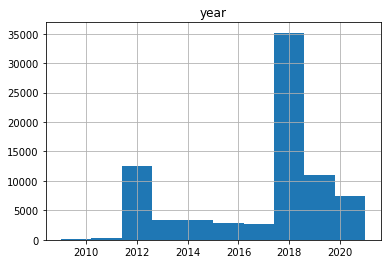

In [ ]:
spark.sql('SELECT YEAR(date) AS year FROM df').toPandas().hist();

Assigning a sentiment score to each tweet


In [ ]:
decode_udf= udf(lambda val: val.encode('utf-8').decode('utf-8'))
df.withColumn('decoded_tweet', decode_udf('tweet'))

DataFrame[id: string, conversation_id: string, created_at: string, date: string, time: string, timezone: string, user_id: string, username: string, name: string, place: string, tweet: string, language: string, mentions: string, urls: string, photos: string, replies_count: string, retweets_count: string, likes_count: string, hashtags: string, cashtags: string, link: string, retweet: string, quote_url: string, video: string, thumbnail: string, near: string, geo: string, source: string, user_rt_id: string, user_rt: string, retweet_id: string, reply_to: string, retweet_date: string, translate: string, trans_src: string, trans_dest: string, decoded_tweet: string]

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- conversation_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- username: string (nullable = true)
 |-- name: string (nullable = true)
 |-- place: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- language: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- urls: string (nullable = true)
 |-- photos: string (nullable = true)
 |-- replies_count: string (nullable = true)
 |-- retweets_count: string (nullable = true)
 |-- likes_count: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- cashtags: string (nullable = true)
 |-- link: string (nullable = true)
 |-- retweet: string (nullable = true)
 |-- quote_url: string (nullable = true)
 |-- video: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- near

In [ ]:
decode_udf= udf(lambda val: val.encode('utf-8').decode('utf-8') if val else ' ')
df_decoded = df.withColumn('decoded_tweet', decode_udf('tweet'))
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register('sentiment', sentiment)
df_sentiment=df_decoded.withColumn('sentiment',sentiment('decoded_tweet').cast('float'))
df_sentiment.show()

+-------------------+-------------------+--------------------+----------+--------+--------+-------------------+------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+-----+--------------------+----+----+------+----------+-------+----------+--------------------+------------+---------+---------+----------+--------------------+-----------+
|                 id|    conversation_id|          created_at|      date|    time|timezone|            user_id|    username|                name|place|               tweet|            language|            mentions|                urls|              photos|replies_count|retweets_count|likes_count|            hashtags|            cashtags|                link|             retweet|quote_url|video|           thumbnail|near| geo|source|u

In [ ]:
from pyspark.sql.functions import col, when

def blank_as_null(x):
    return when(col(x) != "", col(x)).otherwise(None)

dfWithEmptyReplaced = df_sentiment.withColumn("tweet", blank_as_null("tweet"))

dfWithEmptyReplaced.show()

+-------------------+-------------------+--------------------+----------+--------+--------+-------------------+------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+-----+--------------------+----+----+------+----------+-------+----------+--------------------+------------+---------+---------+----------+--------------------+-----------+
|                 id|    conversation_id|          created_at|      date|    time|timezone|            user_id|    username|                name|place|               tweet|            language|            mentions|                urls|              photos|replies_count|retweets_count|likes_count|            hashtags|            cashtags|                link|             retweet|quote_url|video|           thumbnail|near| geo|source|u

In [ ]:
dfWithEmptyReplaced.createOrReplaceTempView('dfWithEmptyReplaced')

In [ ]:
# Filter by sentiment existing
df2 = dfWithEmptyReplaced.filter("sentiment!=0.0").select(['username','tweet', 'date', 'mentions','replies_count','reply_to','retweets_count','likes_count','hashtags', 'sentiment'])
df2.show()

+------------+--------------------+----------+--------------------+-------------+--------------------+--------------+-----------+--------------------+-----------+
|    username|               tweet|      date|            mentions|replies_count|            reply_to|retweets_count|likes_count|            hashtags|  sentiment|
+------------+--------------------+----------+--------------------+-------------+--------------------+--------------+-----------+--------------------+-----------+
|     k12ssdb|Florida Gov. orde...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          2|['parkland', 'sch...|       -0.2|
|     k12ssdb|Threats of school...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          1|['schoolshooting'...|     0.1875|
|     k12ssdb|A 20-year-old man...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          1|['schoolshooting'...| 0.11666667|
|     k12ssdb|Police f

In [ ]:
df2.createOrReplaceTempView('df2')

In [ ]:
query = '''
SELECT AVG(sentiment) as avg, date, tweet, hashtags
FROM df2
GROUP BY date, hashtags, tweet
ORDER BY avg DESC
'''
spark.sql(query).show()

+---+----------+--------------------+--------------------+
|avg|      date|               tweet|            hashtags|
+---+----------+--------------------+--------------------+
|1.0|2014-12-12|What a great kid!...|['schoolshooting'...|
|1.0|2013-05-08|Good News. Parent...|['schoolshooting'...|
|1.0|2018-05-18|Another school sh...|['gunreform', 'sc...|
|1.0|2019-05-08|[2/2]-school on t...|['schoolshooting'...|
|1.0|2018-02-15|En el colegio!!! ...|['schoolshooting'...|
|1.0|2019-11-14|It’s time for mor...|  ['schoolshooting']|
|1.0|2018-02-15|Time to train and...|['israel', 'nra',...|
|1.0|2013-12-09|Awesome! #time #s...|['time', 'schools...|
|1.0|2012-12-14|My prayers are wi...|  ['schoolshooting']|
|1.0|2014-12-12|Reports of a #sch...|  ['schoolshooting']|
|1.0|2018-02-16|Awesome! #hero #s...|['hero', 'schools...|
|1.0|2012-02-28|Great advice! RT ...|['schoolshooting'...|
|1.0|2020-11-12|Defense Stocks; T...|['schoolshooting'...|
|1.0|2012-08-27|Once again @wbalr...|  ['schoolshooting'

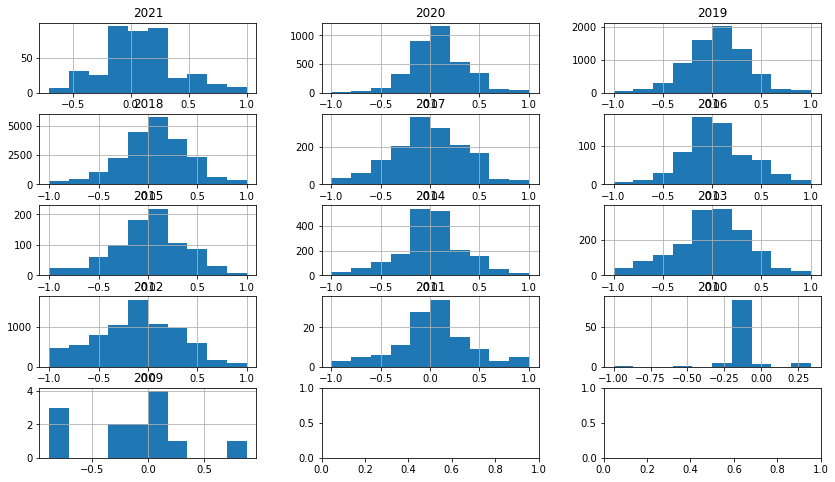

In [ ]:
years_list = [2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009]
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(14,8))
ax = ax.ravel()
for i, year in enumerate(years_list):
  df2.select('sentiment').filter('YEAR(created_at)=={}'.format(year)).toPandas().hist(ax=ax[i])
  ax[i].set_title('{}'.format(year))

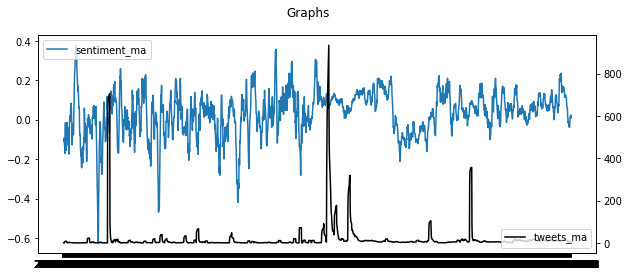

In [ ]:
trend_pdf = df2.select('date', 'sentiment','username')\
                            .groupby('date').agg({'sentiment':'avg','username':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(username)','counttweets')\
                            .toPandas()

rolling_sentiment = trend_pdf.sentiment.rolling(window=10).mean()
rolling_tweets = trend_pdf.counttweets.rolling(window=10).mean()

chart_title = 'Graphs'

fig, ax = plt.subplots(figsize=(10,4), sharex=True)
fig.suptitle('{}'.format(chart_title))
ax0 = plt.subplot(111)
ax1 = ax0.twinx()

ax0.plot(trend_pdf.date, rolling_sentiment, label='sentiment_ma')
ax0.legend(loc='upper left')
ax1.plot(trend_pdf.date, rolling_tweets, label='tweets_ma', c='k')
ax1.legend(loc='lower right');

In [ ]:
 df2.select('tweet').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                                                                                                                                                                           |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Florida Gov. ordered a moment of silence at 3 p.m. Sunday and state flags to be flown at half-staff from sunrise to sunset in 

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_stopwords(x):    
    sw = stopwords.words("english")
    sw += '#schoolshooting', '#schoolshootings', '#SchoolShooting', '#Schoolshooting'
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register('nosw', nosw)
tweets = df2.withColumn('tweet_nosw', nosw('tweet'))
tweets.show()

+------------+--------------------+----------+--------------------+-------------+--------------------+--------------+-----------+--------------------+-----------+--------------------+
|    username|               tweet|      date|            mentions|replies_count|            reply_to|retweets_count|likes_count|            hashtags|  sentiment|          tweet_nosw|
+------------+--------------------+----------+--------------------+-------------+--------------------+--------------+-----------+--------------------+-----------+--------------------+
|     k12ssdb|Florida Gov. orde...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          2|['parkland', 'sch...|       -0.2|Florida Gov. orde...|
|     k12ssdb|Threats of school...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          1|['schoolshooting'...|     0.1875|Threats school vi...|
|     k12ssdb|A 20-year-old man...|2021-02-13|[{'screen_name': ...|            0

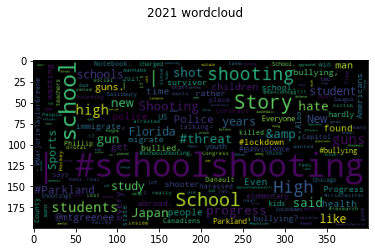

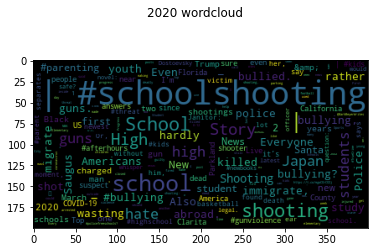

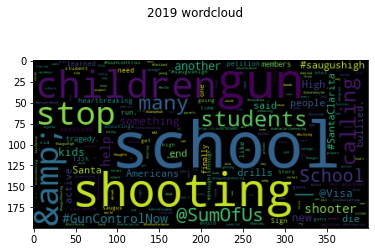

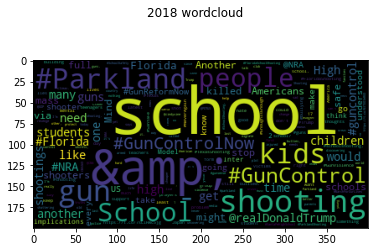

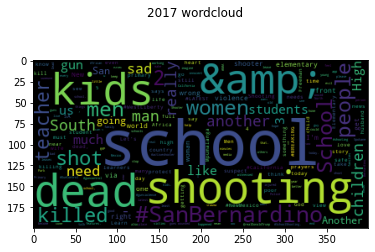

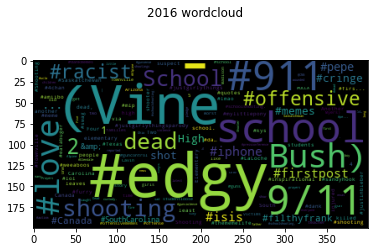

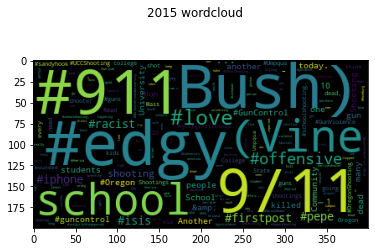

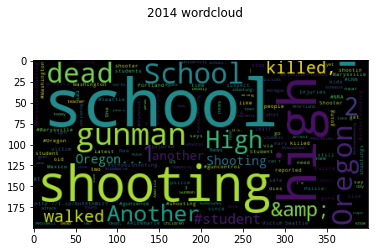

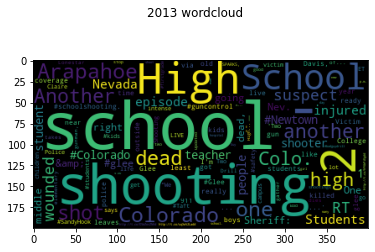

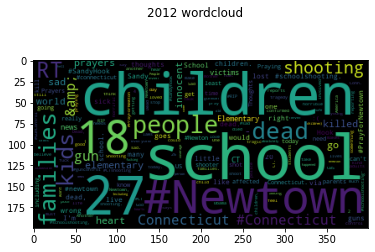

In [ ]:
def flat_list(column):
    corpus = []
    for row in column:
        for w in row.split(' '):
            corpus.append(w)
    return corpus

def corpus_creator(text_col):
    corpus = text_col.rdd.flatMap(flat_list) \
                    .map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x+y ) \
                    .sortBy(lambda x: x[1], ascending=False) \
                    .toDF() \
                    .withColumnRenamed('_1','tweet') \
                    .withColumnRenamed('_2','count')
    return corpus

def annual_tweets(year):
    annual_tweets = tweets.select('tweet_nosw') \
                        .filter('YEAR(created_at)=={}'.format(year)) \
                        .withColumnRenamed('tweet_nosw','tweet')
    return annual_tweets

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['tweet']] = row['count']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);


years_list = [2021,2020,2019,2018,2017,2016,2015, 2014, 2013, 2012]

annual_corpora = {}
for year in years_list:
    annual_corpora[str(year)] = corpus_creator(annual_tweets(year))

for key,value in annual_corpora.items():
    fig, ax = plt.subplots()
    ax = wordcloud(value)
    fig.suptitle('{} wordcloud'.format(key))

In [ ]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
tweets = df2.withColumn('sentiment',sentiment('tweet').cast('float'))
tweets.show()

+------------+--------------------+----------+--------------------+-------------+--------------------+--------------+-----------+--------------------+-----------+
|    username|               tweet|      date|            mentions|replies_count|            reply_to|retweets_count|likes_count|            hashtags|  sentiment|
+------------+--------------------+----------+--------------------+-------------+--------------------+--------------+-----------+--------------------+-----------+
|     k12ssdb|Florida Gov. orde...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          2|['parkland', 'sch...|       -0.2|
|     k12ssdb|Threats of school...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          1|['schoolshooting'...|     0.1875|
|     k12ssdb|A 20-year-old man...|2021-02-13|[{'screen_name': ...|            0|                  []|             1|          1|['schoolshooting'...| 0.11666667|
|     k12ssdb|Police f

In [ ]:
print(tweets)

DataFrame[username: string, tweet: string, date: string, mentions: string, replies_count: string, reply_to: string, retweets_count: string, likes_count: string, hashtags: string, sentiment: float]


DataFrame[username: string, tweet: string, date: string, mentions: string, replies_count: string, reply_to: string, retweets_count: string, likes_count: string, hashtags: string, sentiment: float]


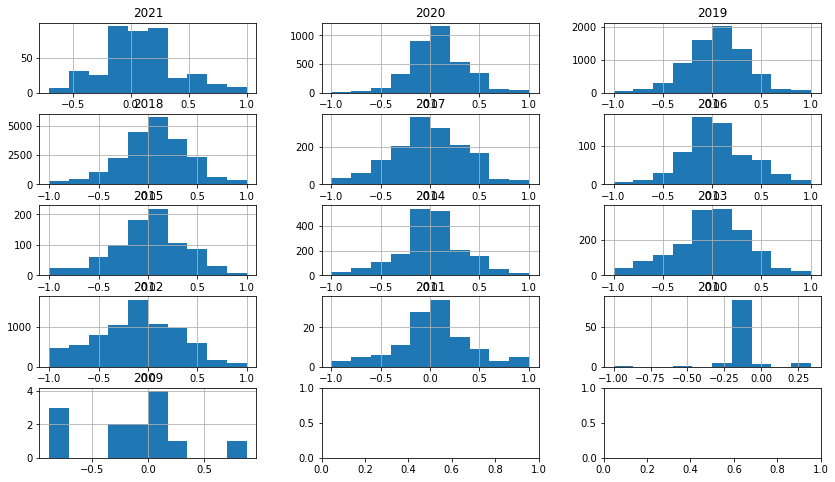

In [ ]:
print(tweets)
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(14,8))
ax = ax.ravel()
for i, year in enumerate(years_list):
  tweets.select('sentiment')\
    .filter('YEAR(created_at)=={}'.format(year))\
    .toPandas()\
    .hist(ax=ax[i])
  ax[i].set_title('{}'.format(year))